# Subreddit Embeddings: Vector representations of subreddits and users' subreddit histories

## Setup

In [1]:
import json
import numpy as np
from scipy.sparse import bsr_matrix, coo_matrix, csr_matrix, lil_matrix, identity
from matplotlib import pyplot as plt

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.word2vec import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

In [2]:
# with open("stored_variables/politics_author_history.json", "r") as f:
#     politics_author_history = json.load(f)
with open("stored_variables/politics_author_history2.json", "r") as f:
    politics_author_history = json.load(f)

In [5]:
input_subreddit_list = []
author_names = []

for k in politics_author_history.keys():
    input_subreddit_list.append(sorted(politics_author_history[k], key = lambda x : x[1]))
    author_names.append(k)

In [6]:
input_subreddit_list = [[x[0] for x in l] for l in input_subreddit_list]

In [21]:
color_vals = ['red', 'blue', 'green', 'orange', 'purple', 'black', 'cyan', 'magenta', 'yellow', 'brown']

In [7]:
all_subreddits = sorted(list(set([i for l in input_subreddit_list for i in l])))
subreddit_reverse_dict = {all_subreddits[i] : i for i in range(len(all_subreddits))}
subreddit_tf = lil_matrix((len(input_subreddit_list), len(all_subreddits)))
subreddit_df_mat = lil_matrix((len(input_subreddit_list), len(all_subreddits)))

for i in range(len(input_subreddit_list)):
    for s in input_subreddit_list[i]:
        subreddit_tf[i, subreddit_reverse_dict[s]] = subreddit_tf[i, subreddit_reverse_dict[s]] + 1
        subreddit_df_mat[i, subreddit_reverse_dict[s]] = 1


In [8]:
subreddit_tf = csr_matrix(subreddit_tf)

In [9]:
subreddit_df_mat = csr_matrix(subreddit_df_mat)

In [12]:
print(len(np.array(np.sum(subreddit_tf, axis=0).transpose())))
print(len(all_subreddits))
print(subreddit_tf.shape)
print(subreddit_df_mat.shape)

41900
41900
(20000, 41900)
(20000, 41900)


In [13]:
subreddit_df = subreddit_df_mat.sum(axis=0)
subreddit_idf = len(input_subreddit_list) / subreddit_df

In [14]:
print(subreddit_df.shape)
print(subreddit_idf.shape)

(1, 41900)
(1, 41900)


In [15]:
subreddit_tfidf = subreddit_tf.multiply(subreddit_idf)

In [16]:
subreddit_tfidf = subreddit_tfidf / subreddit_tfidf.sum(axis=1)

In [17]:
print(subreddit_tfidf.shape)
print(subreddit_tfidf.sum(axis=1).shape)

(20000, 41900)
(20000, 1)


In [77]:
subreddit_freqs = np.array(subreddit_tf.sum(axis=0))[0]

In [18]:
subreddit_df_arr = np.array(subreddit_df)[0]

In [21]:
# only use subreddits that at least 10 people have commented in 
good_subreddits = [i for i in range(len(all_subreddits)) if subreddit_df_arr[i] >= 10 and all_subreddits[i] != 'politics']
good_subreddit_names = [all_subreddits[i] for i in good_subreddits]
good_subreddit_reverse_dict = {good_subreddit_names[i] : i for i in range(len(good_subreddit_names))}
print(len(good_subreddits))

8446


In [23]:
subreddit_tf_good = subreddit_tf[:, good_subreddits]
subreddit_df_good = subreddit_df_mat[:, good_subreddits]

## Descriptive statistics

(array([1.9203e+04, 6.0200e+02, 1.3600e+02, 3.3000e+01, 1.5000e+01,
        4.0000e+00, 4.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.20820e+03, 1.44154e+04, 2.16226e+04, 2.88298e+04,
        3.60370e+04, 4.32442e+04, 5.04514e+04, 5.76586e+04, 6.48658e+04,
        7.20730e+04]),
 <a list of 10 Patch objects>)

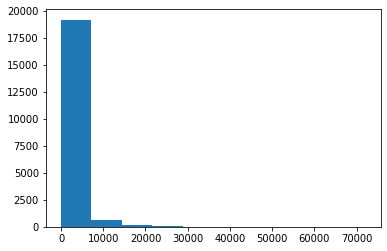

In [8]:
history_lengths = [len(l) for l in input_subreddit_list]

plt.hist(history_lengths)

(array([9754., 3260., 1734., 1166.,  799.,  598.,  409.,  377.,  273.,
         223.]),
 array([1.0000e+00, 5.0070e+02, 1.0004e+03, 1.5001e+03, 1.9998e+03,
        2.4995e+03, 2.9992e+03, 3.4989e+03, 3.9986e+03, 4.4983e+03,
        4.9980e+03]),
 <a list of 10 Patch objects>)

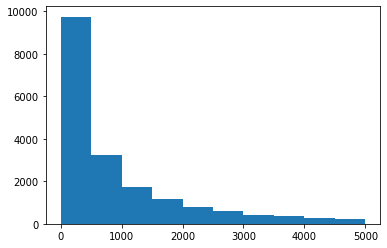

In [9]:
plt.hist([i for i in history_lengths if i < 5000])

(array([4048., 2071., 1487., 1149.,  995.,  888.,  706.,  598.,  546.,
         519.]),
 array([  1. , 100.8, 200.6, 300.4, 400.2, 500. , 599.8, 699.6, 799.4,
        899.2, 999. ]),
 <a list of 10 Patch objects>)

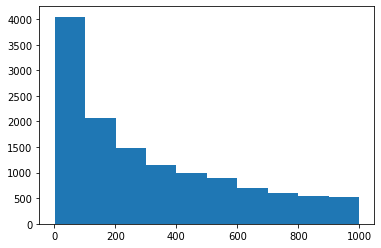

In [10]:
plt.hist([i for i in history_lengths if i < 1000])

In [11]:
print("Mean history length:", np.mean(history_lengths))
print("Median history length:", np.median(history_lengths))
print("Standard deviation of history lengths:", np.std(history_lengths))
print("Total number of comments:", sum(history_lengths))

Mean history length: 1513.84625
Median history length: 526.0
Standard deviation of history lengths: 2977.5964636449544
Total number of comments: 30276925


### Top subreddits

In [79]:
top_subreddits = [(all_subreddits[i], int(subreddit_freqs[i])) for i in np.argsort(subreddit_freqs)]
top_subreddits.reverse()

for i in top_subreddits[:50]:
    print(i[0] + ": " + str(i[1]))

AskReddit: 2738541
politics: 1107231
funny: 883702
pics: 841453
worldnews: 627095
AdviceAnimals: 543976
todayilearned: 522466
WTF: 512200
videos: 508640
nfl: 506920
news: 504733
gaming: 479634
leagueoflegends: 397207
atheism: 326797
nba: 319636
movies: 288344
soccer: 261230
CFB: 255504
technology: 235772
IAmA: 222971
hockey: 202142
SandersForPresident: 172796
SquaredCircle: 172192
reddit.com: 151676
DotA2: 144242
gifs: 141865
Games: 137640
trees: 131711
pcmasterrace: 130494
explainlikeimfive: 118264
PoliticalDiscussion: 116367
fantasyfootball: 116155
aww: 110073
science: 108021
Music: 101480
Fitness: 101282
canada: 100233
Android: 99286
The_Donald: 96076
MMA: 95674
relationships: 89377
conspiracy: 87115
TumblrInAction: 86655
GlobalOffensive: 83699
starcraft: 82440
asoiaf: 81118
DestinyTheGame: 79910
wow: 78847
hiphopheads: 78791
Bitcoin: 75833


In [80]:
print(subreddit_freqs[subreddit_reverse_dict['The_Donald']])
print(subreddit_freqs[subreddit_reverse_dict['SandersForPresident']])
print(subreddit_freqs[subreddit_reverse_dict['hillaryclinton']])

96076.0
172796.0
14581.0


In [86]:
top_subreddits_df = [(all_subreddits[i], int(subreddit_df_arr[i])) for i in np.argsort(subreddit_df_arr)]
top_subreddits_df.reverse()

for i in top_subreddits_df[:50]:
    print(i[0] + ": " + str(i[1]))

politics: 20000
AskReddit: 16951
pics: 15100
funny: 15093
todayilearned: 14144
worldnews: 13424
videos: 13080
news: 11954
WTF: 11953
IAmA: 11914
gaming: 11793
AdviceAnimals: 11668
movies: 10585
gifs: 9542
technology: 9487
aww: 9455
Music: 8853
atheism: 8335
science: 7825
explainlikeimfive: 7558
Showerthoughts: 6689
mildlyinteresting: 6639
nottheonion: 5694
SandersForPresident: 5473
television: 5319
LifeProTips: 5075
trees: 4920
tifu: 4758
bestof: 4647
books: 4456
pcmasterrace: 4259
food: 4221
cringepics: 4210
Futurology: 3910
Fitness: 3898
woahdude: 3882
sports: 3797
dataisbeautiful: 3742
reactiongifs: 3602
OldSchoolCool: 3553
nfl: 3535
personalfinance: 3531
Jokes: 3506
BlackPeopleTwitter: 3453
interestingasfuck: 3391
askscience: 3375
The_Donald: 3354
DIY: 3329
TwoXChromosomes: 3324
creepy: 3246


In [87]:
print(subreddit_df_arr[subreddit_reverse_dict['The_Donald']])
print(subreddit_df_arr[subreddit_reverse_dict['SandersForPresident']])
print(subreddit_df_arr[subreddit_reverse_dict['hillaryclinton']])

3354.0
5473.0
688.0


In [91]:
print(subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']]).sum())

1903.0
262.0
535.0


## Create Doc2Vec embeddings of the subreddits

In [29]:
user_docs = [TaggedDocument(input_subreddit_list[i], [author_names[i]]) for i in range(len(input_subreddit_list))]
subreddit_hist_model = Doc2Vec(user_docs, vector_size=50, window=10, min_count=5)

In [30]:
user_docs[0]

TaggedDocument(words=['reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'programming', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'programming', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'programming', 'programming', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'programming', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit

In [31]:
subreddit_hist_model.docvecs['SolarBear']

array([-1.5225332 , -1.2797916 , -2.6489785 ,  2.1184058 , -3.2641356 ,
       -0.73350555,  1.4697542 , -0.1330298 ,  2.9265554 ,  1.7011793 ,
        0.47272372, -4.201783  , -1.8631821 , -0.8268978 , -0.14215747,
        2.7800646 ,  0.91430765, -0.4829731 , -1.8974884 , -1.4360821 ,
        1.263087  , -0.5379222 ,  0.26193085,  0.76955175, -0.59273934,
       -1.1498041 ,  0.42098817,  4.3020043 , -1.2469797 ,  4.3819604 ,
       -1.5736518 , -0.70822537, -3.3666725 , -1.6627655 ,  0.57586205,
       -0.46565554, -2.3056855 ,  0.7670798 ,  3.2596152 ,  0.21569939,
       -0.7564261 ,  1.1909256 , -1.7105424 , -2.4335127 , -0.03923102,
       -1.6793612 , -0.04859662, -1.7926782 ,  1.0562471 ,  1.5725923 ],
      dtype=float32)

In [32]:
subreddit_hist_vecs = np.array([subreddit_hist_model.docvecs[i] for i in author_names])

## Visualize document vectors with PCA and T-SNE

In [33]:
subreddit_doc2vec_pca = PCA(n_components=2)
subreddit_doc2vec_pca_points = subreddit_doc2vec_pca.fit_transform(subreddit_hist_vecs)
subreddit_doc2vec_pca.explained_variance_ratio_

array([0.08203422, 0.04892498], dtype=float32)

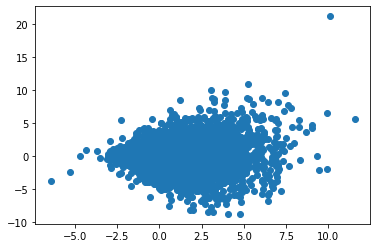

In [34]:
plt.scatter(subreddit_doc2vec_pca_points[:,0], subreddit_doc2vec_pca_points[:,1])
plt.show()

In [35]:
subreddit_tsne = TSNE(n_components=2)
subreddit_tsne_points = subreddit_tsne.fit_transform(subreddit_hist_vecs)

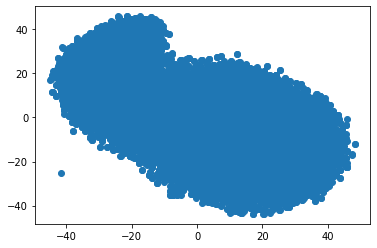

In [36]:
plt.scatter(subreddit_tsne_points[:,0], subreddit_tsne_points[:,1])
plt.show()

## K-means clustering

In [37]:
km2 = KMeans(n_clusters=2)
km2.fit(subreddit_hist_vecs)
km2_labels = km2.labels_
km2_label_colors = [color_vals[i] for i in km2_labels]

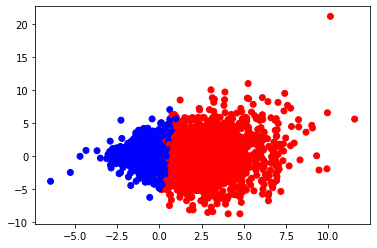

In [39]:
plt.scatter(subreddit_doc2vec_pca_points[:,0], subreddit_doc2vec_pca_points[:,1], c=km2_label_colors)
plt.show()

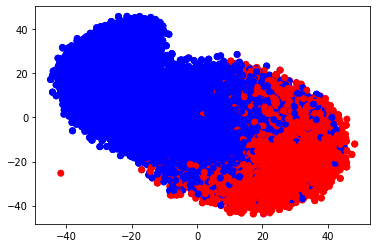

In [40]:
plt.scatter(subreddit_tsne_points[:,0], subreddit_tsne_points[:,1], c=km2_label_colors)
plt.show()

In [42]:
km3 = KMeans(n_clusters=3)
km3.fit(subreddit_hist_vecs)
km3_label_colors = [color_vals[i] for i in km3.labels_]

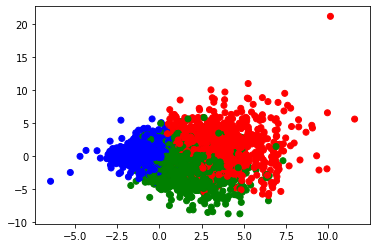

In [43]:
plt.scatter(subreddit_doc2vec_pca_points[:,0], subreddit_doc2vec_pca_points[:,1], c=km3_label_colors)
plt.show()

In [44]:
km4 = KMeans(n_clusters=4)
km4.fit(subreddit_hist_vecs)
km4_label_colors = [color_vals[i] for i in km4.labels_]

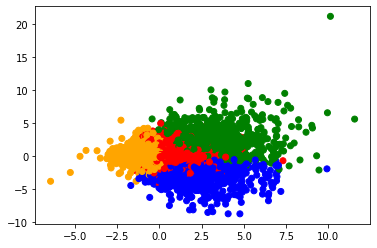

In [45]:
plt.scatter(subreddit_doc2vec_pca_points[:,0], subreddit_doc2vec_pca_points[:,1], c=km4_label_colors)
plt.show()

## PCA and clustering on original subreddit vectors

In [20]:
raw_pca = TruncatedSVD(n_components=50)
raw_pca_points = raw_pca.fit_transform(subreddit_tfidf)
raw_pca.explained_variance_ratio_

array([0.07248657, 0.00672386, 0.00461688, 0.00306848, 0.00257347,
       0.00250961, 0.00194545, 0.00169919, 0.00155961, 0.00153695,
       0.00144235, 0.00142763, 0.00136479, 0.00124337, 0.00116575,
       0.00109914, 0.00104876, 0.00105455, 0.0010457 , 0.00102974,
       0.00102781, 0.0009408 , 0.00091365, 0.00091694, 0.00090232,
       0.00087182, 0.00085285, 0.00084663, 0.00084602, 0.00084297,
       0.00083646, 0.00083523, 0.00082574, 0.00081948, 0.00080921,
       0.00080239, 0.00079546, 0.00076311, 0.00075796, 0.00074888,
       0.00073874, 0.00073311, 0.00072434, 0.00071461, 0.0007011 ,
       0.00069963, 0.00069069, 0.00068763, 0.00067231, 0.00066932])

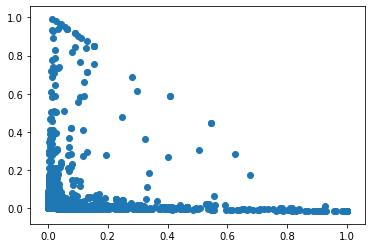

In [18]:
plt.scatter(raw_pca_points[:,0], raw_pca_points[:,1])
plt.show()

In [19]:
# importance order might be misleading: largest coefficients
subreddit_importance_order1 = list(np.argsort(np.abs(raw_pca.components_[0])))
subreddit_importance_order1.reverse()

for i in range(20):
    print(all_subreddits[subreddit_importance_order1[i]])
    
print()

subreddit_importance_order2 = list(np.argsort(np.abs(raw_pca.components_[1])))
subreddit_importance_order2.reverse()

for i in range(20):
    print(all_subreddits[subreddit_importance_order2[i]])

politics
news
SandersForPresident
AskReddit
The_Donald
worldnews
funny
videos
pics
PoliticalDiscussion
movies
IAmA
hillaryclinton
atheism
aww
AdviceAnimals
Conservative
todayilearned
Showerthoughts
enoughsandersspam

The_Donald
SandersForPresident
Mr_Trump
AskReddit
AskTrumpSupporters
news
worldnews
pics
politics
PoliticalDiscussion
Conservative
hillaryclinton
BernieSandersSucks
funny
leagueoflegends
todayilearned
GlobalOffensive
HillaryForPrison
reactiongifs
canada


In [22]:
km2_pca = KMeans(n_clusters=2)
km2_pca.fit(raw_pca_points)
km2_pca_label_colors = [color_vals[i] for i in km2_pca.labels_]

In [27]:
km10_pca = KMeans(n_clusters=10)
km10_pca.fit(raw_pca_points)
km10_pca_label_colors = [color_vals[i] for i in km10_pca.labels_]

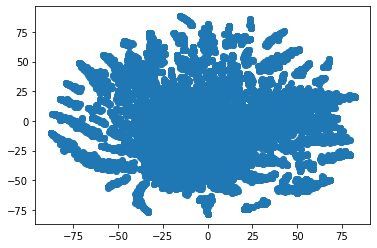

In [23]:
raw_tsne = TSNE(n_components=2)
raw_tsne_points = raw_tsne.fit_transform(raw_pca_points)
plt.scatter(raw_tsne_points[:,0], raw_tsne_points[:,1])
plt.show()

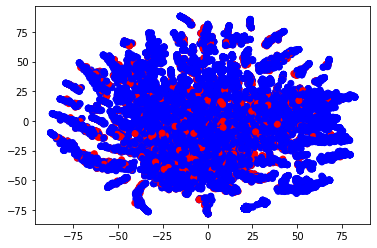

In [46]:
plt.scatter(raw_tsne_points[:,0], raw_tsne_points[:,1], c = km2_label_colors)
plt.show()

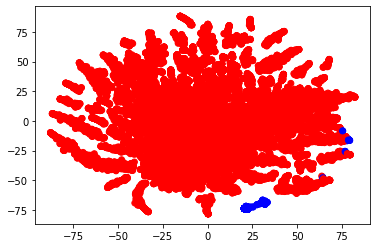

In [26]:
plt.scatter(raw_tsne_points[:,0], raw_tsne_points[:,1], c = km2_pca_label_colors)
plt.show()

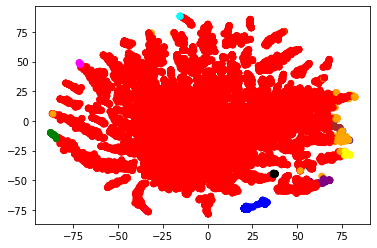

In [28]:
plt.scatter(raw_tsne_points[:,0], raw_tsne_points[:,1], c = km10_pca_label_colors)
plt.show()

In [96]:
subreddit_pca_vecs = raw_pca.transform(identity(len(all_subreddits)))

In [30]:
subreddit_pca_tsne = TSNE(n_components=2)
subreddit_pca_tsne_points = subreddit_pca_tsne.fit_transform(subreddit_pca_vecs)
plt.scatter(subreddit_pca_tsne_points[:,0], subreddit_pca_tsne_points[:,1])
plt.show()

In [ ]:
km2_sub = KMeans(n_clusters=2)
km2_sub.fit(subreddit_pca_vecs)
km2_sub_label_colors = [color_vals[i] for i in km2_sub.labels_]

In [ ]:
km10_sub = KMeans(n_clusters=10)
km10_sub.fit(subreddit_pca_vecs)
km10_sub_label_colors = [color_vals[i] for i in km10_sub.labels_]

In [ ]:
plt.scatter(subreddit_pca_tsne_points[:,0], subreddit_pca_tsne_points[:,1], c=km2_sub_label_colors)
plt.show()

In [ ]:
plt.scatter(subreddit_pca_tsne_points[:,0], subreddit_pca_tsne_points[:,1], c=km10_sub_label_colors)
plt.show()

In [22]:
good_subreddit_raw_vecs = lil_matrix((len(good_subreddits), len(all_subreddits)))

for i in range(len(good_subreddits)):
    good_subreddit_raw_vecs[i, good_subreddits[i]] = 1
    
good_subreddit_pca_vecs = raw_pca.transform(good_subreddit_raw_vecs)
good_subreddit_pca_vecs

array([[ 1.62451206e-06,  4.52529497e-06,  1.29030971e-05, ...,
         2.61450169e-05, -4.55344663e-06,  2.64324538e-04],
       [ 5.21528529e-07,  1.48240272e-06,  4.25074849e-06, ...,
        -8.15095124e-05,  7.77625107e-06,  5.52946871e-05],
       [ 7.52880561e-08,  9.18585288e-07,  1.75363120e-06, ...,
         2.75025165e-05, -6.88207689e-06, -4.73588376e-05],
       ...,
       [ 1.40800635e-07,  1.83191535e-06,  3.24720958e-06, ...,
        -2.92476518e-04, -2.94675011e-05,  5.98270609e-04],
       [ 4.77833830e-07,  1.09381659e-06,  2.25112321e-06, ...,
         2.09613179e-05,  4.57650140e-05, -2.79117710e-05],
       [ 7.90887647e-08,  2.94266415e-06,  5.59782645e-06, ...,
        -1.79836323e-04,  3.97732611e-05,  1.75902223e-04]])

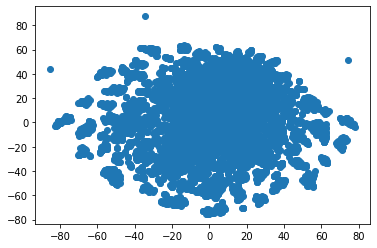

In [99]:
good_subreddit_pca_tsne = TSNE(n_components=2)
good_subreddit_pca_tsne_points = subreddit_pca_tsne.fit_transform(good_subreddit_pca_vecs)
plt.scatter(good_subreddit_pca_tsne_points[:,0], good_subreddit_pca_tsne_points[:,1])
plt.show()

In [100]:
km2_sub_good = KMeans(n_clusters=2)
km2_sub_good.fit(good_subreddit_pca_vecs)
km2_sub_good_label_colors = [color_vals[i] for i in km2_sub_good.labels_]

In [101]:
km10_sub_good = KMeans(n_clusters=10)
km10_sub_good.fit(good_subreddit_pca_vecs)
km10_sub_good_label_colors = [color_vals[i] for i in km10_sub_good.labels_]

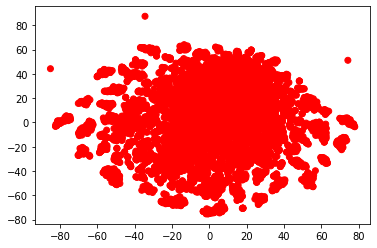

In [102]:
plt.scatter(good_subreddit_pca_tsne_points[:,0], good_subreddit_pca_tsne_points[:,1], c=km2_sub_good_label_colors)
plt.show()

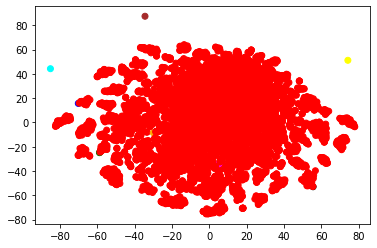

In [103]:
plt.scatter(good_subreddit_pca_tsne_points[:,0], good_subreddit_pca_tsne_points[:,1], c=km10_sub_good_label_colors)
plt.show()

In [107]:
subreddit_sims = np.matmul(good_subreddit_pca_vecs, good_subreddit_pca_vecs.transpose())

top_subreddits_sim = []

for i in range(len(good_subreddits)):
    sim_vals = subreddit_sims[i]
    sub_names = [good_subreddit_names[i] for i in np.argsort(sim_vals)]
    sub_names.reverse()
    top_subreddits_sim.append(sub_names)

In [110]:
print(top_subreddits_sim[good_subreddit_reverse_dict['The_Donald']][:20])
print(top_subreddits_sim[good_subreddit_reverse_dict['SandersForPresident']][:20])
print(top_subreddits_sim[good_subreddit_reverse_dict['hillaryclinton']][:20])
print(top_subreddits_sim[good_subreddit_reverse_dict['politics']][:20])
print(top_subreddits_sim[good_subreddit_reverse_dict['AskReddit']][:20])
print(top_subreddits_sim[good_subreddit_reverse_dict['nba']][:20])
print(top_subreddits_sim[good_subreddit_reverse_dict['sanfrancisco']][:20])
print(top_subreddits_sim[good_subreddit_reverse_dict['wisconsin']][:20])

['The_Donald', 'BernieSandersSucks', 'Conservative', 'reactiongifs', 'HillaryForPrison', 'canada', 'me_irl', 'republicans', 'pics', 'gaybros', 'unitedkingdom', 'interstellar', 'WomenForTrump', 'todayilearned', 'HighQualityGifs', 'Tinder', 'bassfishing', 'GlobalOffensive', 'KotakuInAction', 'AgainstHateSubreddits']
['SandersForPresident', 'trees', 'NewYorkForSanders', 'spacex', 'todayilearned', 'conspiracy', 'Michigan4Sanders', 'GrassrootsSelect', 'MachineLearning', 'kingforpresident', 'jailbreak', 'legaladvice', 'Maher', 'WashingtonForSanders', 'IowaForSanders', 'CaliforniaForSanders', 'food', 'teslamotors', 'NevadaForSanders', 'neuroscience']
['hillaryclinton', 'GlobalOffensive', 'eu4', 'smashbros', 'RoastMe', 'aww', 'law', 'humblebrag', 'ShinyPokemon', 'teenagers', 'AgeofMythology', 'rutgers', 'ipad', 'vancouver', 'ProtectAndServe', 'GrassrootsSelect', 'RealGirls', 'fantasybaseball', 'financialindependence', 'TwoBestFriendsPlay']
['politics', 'videos', 'IAmA', 'movies', 'Conservative

## Word2Vec

In [111]:
subreddit_w2v_model = Word2Vec(input_subreddit_list, size=50, window=100, min_count=10)

In [112]:
print(subreddit_w2v_model.wv.most_similar(positive=['The_Donald']))
print(subreddit_w2v_model.wv.most_similar(positive=['SandersForPresident']))
print(subreddit_w2v_model.wv.most_similar(positive=['hillaryclinton']))
print(subreddit_w2v_model.wv.most_similar(positive=['nba']))
print(subreddit_w2v_model.wv.most_similar(positive=['Frugal']))
print(subreddit_w2v_model.wv.most_similar(positive=['sanfrancisco']))
print(subreddit_w2v_model.wv.most_similar(positive=['Mr_Trump']))

[('USElectionsITA', 0.6623275876045227), ('HillaryForPrison', 0.6129806637763977), ('s4t', 0.607902467250824), ('nothingeverhappens', 0.5818716287612915), ('Mr_Trump', 0.5553396940231323), ('AskTrumpSupporters', 0.551846981048584), ('KasichForPresident', 0.549453854560852), ('donaldtrump', 0.5464745759963989), ('POTUSElection2016', 0.5286298990249634), ('JebBush', 0.5131363868713379)]
[('GrassrootsSelect', 0.6717744469642639), ('Miitomo', 0.5734198093414307), ('NewYorkForSanders', 0.5672667026519775), ('fuckolly', 0.540138840675354), ('Hillary', 0.5398945808410645), ('jillstein', 0.5339994430541992), ('HillaryForPrison', 0.5317246913909912), ('governorsball', 0.5295132398605347), ('LCDSoundsystem', 0.5244836211204529), ('CrestedGecko', 0.5229498147964478)]
[('badwomensanatomy', 0.5554134249687195), ('boxoffice', 0.5527502298355103), ('MyPPDSupport', 0.5239694118499756), ('enoughsandersspam', 0.5183004140853882), ('KentuckyForSanders', 0.5148372650146484), ('PoliticalDiscussion', 0.5127

In [115]:
print(subreddit_df_arr[subreddit_reverse_dict['USElectionsITA']])
print(subreddit_freqs[subreddit_reverse_dict['USElectionsITA']])
print(subreddit_df_arr[subreddit_reverse_dict['Lund']])
print(subreddit_freqs[subreddit_reverse_dict['Lund']])

2.0
18.0
7.0
28.0


## Community2Vec (Using PPMI)

In [187]:
co_freq_mat = (subreddit_tf_good.T).dot(subreddit_tf_good)
co_exist_mat = (subreddit_df_good.T).dot(subreddit_df_good)

In [188]:
subreddit_df_sums = subreddit_df_good.sum(axis=0)
pmi_denom = (subreddit_df_sums.T).dot(subreddit_df_sums)

In [230]:
pmi_mat = len(input_subreddit_list) * np.array(co_exist_mat) / np.array(pmi_denom)
ppmi_mat = np.where(pmi_mat > 1, pmi_mat, 1)
ppmi_mat = np.log2(ppmi_mat)
ppmi_mat = ppmi_mat / np.linalg.norm(ppmi_mat, 2, axis=1)[:, np.newaxis]

In [231]:
ppmi_sims = np.matmul(ppmi_mat, ppmi_mat.T)

In [162]:
print([good_subreddit_names[i] for i in np.argsort(ppmi_mat[good_subreddit_reverse_dict['The_Donald']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_mat[good_subreddit_reverse_dict['SandersForPresident']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_mat[good_subreddit_reverse_dict['hillaryclinton']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_mat[good_subreddit_reverse_dict['nba']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_mat[good_subreddit_reverse_dict['news']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_mat[good_subreddit_reverse_dict['Music']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_mat[good_subreddit_reverse_dict['sanfrancisco']])[-10:]])

['thedonald', 'NorthAmerican', 'WomenForTrump', 'The_DonaldUnleashed', 'Mr_Trump', 'EllenPaoRapedMe', 'hottiesfortrump', 'europeannationalism', 'The_Donald', 'The_Farage']
['GrassrootsSelect', 'BernTheConvention', 'FloridaForSanders', 'NorthCarolina4Sanders', 'Illinois4Sanders', 'kingforpresident', 'SandersForPresident', 'Georgia4Sanders', 'TimCanova', 'Colorado4Sanders']
['TimCanova', 'jillstein', 'Colorado4Sanders', 'Charlottesville', 'enoughsandersspam', 'NevadaForSanders', 'askhillarysupporters', 'Hillary', 'EnoughTrumpSpam', 'hillaryclinton']
['denvernuggets', 'GoNets', 'LAClippers', 'Mavericks', 'nbacirclejerk', 'clevelandcavs', 'nbaww', 'BasketballTips', 'NBA_Draft', 'nba']
['needabro', 'Corruption', 'celebsunleashed', 'news', 'cedarrapids', 'SCBackstage', 'SCJerk', 'BABYMETAL', 'Primus', 'treemovies']
['Stretched', 'Music', 'staircasewit', 'transformice', 'sportsjerseys', 'MusicInTheMaking', 'DeathProTips', 'needabro', 'BigRoom', 'lanterncorps']
['ProsePorn', 'stanford', 'Monte

In [243]:
print([good_subreddit_names[i] for i in np.argsort(ppmi_sims[good_subreddit_reverse_dict['The_Donald']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_sims[good_subreddit_reverse_dict['SandersForPresident']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_sims[good_subreddit_reverse_dict['hillaryclinton']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_sims[good_subreddit_reverse_dict['Conservative']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_sims[good_subreddit_reverse_dict['nba']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_sims[good_subreddit_reverse_dict['news']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_sims[good_subreddit_reverse_dict['Music']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_sims[good_subreddit_reverse_dict['sanfrancisco']])[-10:]])

['gifs', 'Showerthoughts', 'SandersForPresident', 'CringeAnarchy', 'KotakuInAction', '4chan', 'TumblrInAction', 'BlackPeopleTwitter', 'ImGoingToHellForThis', 'The_Donald']
['mildlyinfuriating', 'television', 'cringepics', 'interestingasfuck', 'gifs', 'reactiongifs', 'Showerthoughts', 'news', 'nottheonion', 'SandersForPresident']
['bestof', 'television', 'worldnews', 'enoughsandersspam', 'news', 'SubredditDrama', 'Conservative', 'PoliticalDiscussion', 'SandersForPresident', 'hillaryclinton']
['PoliticalHumor', 'worldpolitics', 'worldnews', 'MensRights', 'PoliticalDiscussion', 'Republican', 'news', 'conspiracy', 'Libertarian', 'Conservative']
['CollegeBasketball', 'MMA', 'hockey', 'hiphopheads', 'CFB', 'soccer', 'sports', 'baseball', 'nfl', 'nba']
['bestof', 'AskReddit', 'funny', 'IAmA', 'pics', 'videos', 'explainlikeimfive', 'todayilearned', 'worldnews', 'news']
['AdviceAnimals', 'AskReddit', 'todayilearned', 'movies', 'funny', 'pics', 'videos', 'WTF', 'IAmA', 'Music']
['bicycling', 'IA

In [224]:
ppmi_pca = TruncatedSVD(n_components=50)
ppmi_pca_points = ppmi_pca.fit_transform(ppmi_mat)
ppmi_pca.explained_variance_ratio_

array([0.02943665, 0.02510387, 0.02152238, 0.01741688, 0.01468778,
       0.0127627 , 0.01209769, 0.00852273, 0.00780367, 0.00733019,
       0.00587827, 0.005588  , 0.00525083, 0.00488263, 0.0045741 ,
       0.00443352, 0.00414443, 0.00408242, 0.00391288, 0.00371789,
       0.0036054 , 0.00344261, 0.00341718, 0.00337088, 0.00319732,
       0.0030945 , 0.00298077, 0.00283807, 0.00278212, 0.00274767,
       0.00260662, 0.00257986, 0.00248711, 0.00245994, 0.00243562,
       0.00240316, 0.00232783, 0.00230703, 0.0022677 , 0.0021924 ,
       0.00215953, 0.00215625, 0.00208144, 0.00207409, 0.00204755,
       0.00202169, 0.00199609, 0.00196778, 0.00191889, 0.00184697])

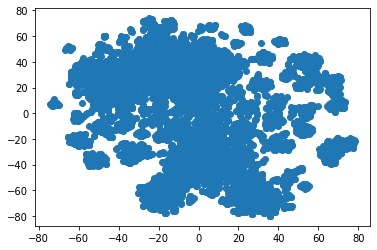

In [244]:
ppmi_tsne = TSNE(n_components=2)
ppmi_tsne_points = ppmi_tsne.fit_transform(ppmi_pca_points)
plt.scatter(ppmi_tsne_points[:,0], ppmi_tsne_points[:,1])
plt.show()

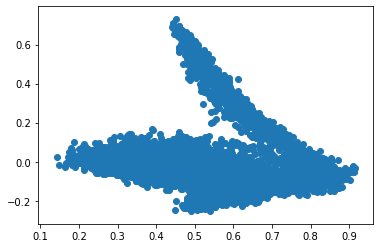

In [226]:
plt.scatter(ppmi_pca_points[:,0], ppmi_pca_points[:,1])
plt.show()

In [247]:
ppmi_pca_norms = np.linalg.norm(ppmi_pca_points, 2, axis = 1)
ppmi_pca_points_normalized = ppmi_pca_points / ppmi_pca_norms[:, np.newaxis]

In [248]:
ppmi_pca_sims = np.matmul(ppmi_pca_points_normalized, ppmi_pca_points_normalized.T)

In [253]:
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['The_Donald']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['SandersForPresident']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['hillaryclinton']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['Conservative']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['Liberal']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['nba']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['lakers']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['news']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['Music']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['AskReddit']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['sanfrancisco']])[-10:]])

['Showerthoughts', 'pussypassdenied', 'punchablefaces', 'TumblrInAction', 'CringeAnarchy', 'RoastMe', 'KotakuInAction', 'BlackPeopleTwitter', 'SandersForPresident', 'The_Donald']
['announcements', 'AskReddit', 'explainlikeimfive', 'The_Donald', 'OutOfTheLoop', 'nottheonion', 'television', 'Blackout2015', 'news', 'SandersForPresident']
['SubredditDrama', 'television', 'Republican', 'changemyview', 'news', 'PoliticalDiscussion', 'Conservative', 'enoughsandersspam', 'SandersForPresident', 'hillaryclinton']
['Liberal', 'worldpolitics', 'Bad_Cop_No_Donut', 'conspiracy', 'news', 'PoliticalDiscussion', 'PoliticalHumor', 'Republican', 'Libertarian', 'Conservative']
['law', 'Libertarian', 'economy', 'Republican', 'socialism', 'PoliticalDiscussion', 'inthenews', 'democrats', 'progressive', 'Liberal']
['nflstreams', 'nbastreams', 'lakers', 'Boxing', 'Patriots', 'sports', 'hockey', 'nfl', 'baseball', 'nba']
['DetroitPistons', 'nbacirclejerk', 'sixers', 'NBA2k', 'LAClippers', 'NYKnicks', 'nba', 'nb

In [267]:
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['SandersForPresident']] - ppmi_mat[
    good_subreddit_reverse_dict['The_Donald']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['The_Donald']] - ppmi_mat[
    good_subreddit_reverse_dict['SandersForPresident']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['hillaryclinton']] - ppmi_mat[
    good_subreddit_reverse_dict['The_Donald']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['The_Donald']] - ppmi_mat[
    good_subreddit_reverse_dict['hillaryclinton']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['SandersForPresident']] - ppmi_mat[
    good_subreddit_reverse_dict['hillaryclinton']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['hillaryclinton']] - ppmi_mat[
    good_subreddit_reverse_dict['SandersForPresident']], ppmi_mat.T))[-10:]])


['wedding', 'Frugal', 'reddit.com', 'Coffee', 'femalefashionadvice', 'crafts', 'secretsanta', 'GrassrootsSelect', 'CaliforniaForSanders', 'SandersForPresident']
['NationalSocialism', 'cumfetish', 'InternetHitlers', 'adorableporn', 'shittydarksouls', 'RepressedGoneWild', 'amateurcumsluts', 'BlackCrimeMatters', 'Mr_Trump', 'The_Donald']
['Bend', 'uchicago', 'Wellington', 'hexandcounter', 'newhaven', 'askhillarysupporters', 'ithaca', 'GrassrootsSelect', 'conservation', 'hillaryclinton']
['pussypassdenied', 'nsfw_gifs', 'trashy', '4chan', 'pcmasterrace', 'fatpeoplehate', 'CringeAnarchy', 'ImGoingToHellForThis', 'BlackPeopleTwitter', 'The_Donald']
['Showerthoughts', 'millionairemakers', 'Unexpected', 'interestingasfuck', 'pcmasterrace', 'reactiongifs', 'woahdude', 'oddlysatisfying', 'BlackPeopleTwitter', 'SandersForPresident']
['uchicago', 'Charlottesville', 'newhaven', 'UniversityofKansas', 'galveston', 'Wellington', 'hexandcounter', 'askhillarysupporters', 'EnoughTrumpSpam', 'hillaryclint

In [266]:
ppmi_pca_points_normalized[good_subreddit_reverse_dict['SandersForPresident']] - ppmi_pca_points_normalized[
    good_subreddit_reverse_dict['The_Donald']]

array([ 0.07144632, -0.00676965, -0.1678663 , -0.05828485, -0.08168022,
        0.05863537, -0.05415053,  0.01392928, -0.09136517,  0.06362206,
       -0.04036679, -0.08417762, -0.03799707, -0.10774514, -0.00199415,
        0.0303105 , -0.04892576, -0.0434103 ,  0.03092581,  0.0261849 ,
        0.00235313,  0.01830116,  0.03669766,  0.00689197,  0.00266609,
        0.0701365 ,  0.02066951, -0.006235  , -0.06601594, -0.05081422,
        0.03325208, -0.00508589,  0.05899041, -0.00823767, -0.00057446,
       -0.00891737,  0.01721557,  0.03007679,  0.02324157,  0.00443948,
        0.00771976, -0.00327259, -0.06489751,  0.00375844, -0.0419319 ,
       -0.0148068 ,  0.05876449,  0.00183262, -0.04471058, -0.03598803])

In [268]:
np.matmul(ppmi_pca_points_normalized[good_subreddit_reverse_dict['SandersForPresident']] - ppmi_pca_points_normalized[
    good_subreddit_reverse_dict['The_Donald']], ppmi_pca_points_normalized.T)

array([0.06189145, 0.1393929 , 0.06211759, ..., 0.10574588, 0.03574773,
       0.02003008])

In [269]:
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_pca_points_normalized[good_subreddit_reverse_dict['SandersForPresident']] - ppmi_pca_points_normalized[
    good_subreddit_reverse_dict['The_Donald']], ppmi_pca_points_normalized.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_pca_points_normalized[good_subreddit_reverse_dict['The_Donald']] - ppmi_pca_points_normalized[
    good_subreddit_reverse_dict['SandersForPresident']], ppmi_pca_points_normalized.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_pca_points_normalized[good_subreddit_reverse_dict['hillaryclinton']] - ppmi_pca_points_normalized[
    good_subreddit_reverse_dict['The_Donald']], ppmi_pca_points_normalized.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_pca_points_normalized[good_subreddit_reverse_dict['The_Donald']] - ppmi_pca_points_normalized[
    good_subreddit_reverse_dict['hillaryclinton']], ppmi_pca_points_normalized.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_pca_points_normalized[good_subreddit_reverse_dict['SandersForPresident']] - ppmi_pca_points_normalized[
    good_subreddit_reverse_dict['hillaryclinton']], ppmi_pca_points_normalized.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_pca_points_normalized[good_subreddit_reverse_dict['hillaryclinton']] - ppmi_pca_points_normalized[
    good_subreddit_reverse_dict['SandersForPresident']], ppmi_pca_points_normalized.T))[-10:]])


['SFV', 'veganrecipes', 'ketorage', 'PCOS', 'vegetarianketo', 'whedon', 'RedditCarpool', 'VegRecipes', 'Hypothyroidism', 'ELATeachers']
['blackchickswhitedicks', 'lineups', 'gangbang', 'RepressedGoneWild', 'DumpsterSluts', 'shittydarksouls', 'CuteFemaleCorpses', 'adorableporn', 'tightsqueeze', 'BlackCrimeMatters']
['Albany', 'kingforpresident', 'newhaven', 'savannah', 'Idaho', 'SantaBarbara', 'genetics', 'notredame', 'sociology', 'conservation']
['blackchickswhitedicks', 'avengedsevenfold', 'fuckyeahdrunksluts', 'iAmA_troll_AmA', 'gangbang', 'quiver', 'CuteFemaleCorpses', 'DumpsterSluts', 'ReversedGIFS', 'EllenPaoandfathate']
['EllenPaoandfathate', 'Pontiac', 'avengedsevenfold', 'delusionalcraigslist', 'stockphotowar', 'farmingsimulator', 'GTAReplay', 'GTAGivers', 'TokeSpot', 'GTADupe']
['Rochester', 'UniversityofKansas', 'ithaca', 'Wellington', 'hexandcounter', 'Kossacks_for_Sanders', 'neuroscience', 'maui', 'askhillarysupporters', 'EnoughTrumpSpam']


### Exclude subreddits that greater than 10000 people have commented in

In [233]:
# only use subreddits that at least 10 people have commented in and at most 10000 people have commented in 
good_subreddits2 = [i for i in range(len(all_subreddits)) if subreddit_df_arr[i] >= 10 and subreddit_df_arr[i] <= 10000]
good_subreddit_names2 = [all_subreddits[i] for i in good_subreddits2]
good_subreddit_reverse_dict2 = {good_subreddit_names2[i] : i for i in range(len(good_subreddit_names2))}
print(len(good_subreddits2))
good_subreddit_raw_vecs2 = lil_matrix((len(good_subreddits2), len(all_subreddits)))

for i in range(len(good_subreddits2)):
    good_subreddit_raw_vecs2[i, good_subreddits2[i]] = 1

8434


In [234]:
subreddit_tf_good2 = subreddit_tf[:, good_subreddits2]
subreddit_df_good2 = subreddit_df_mat[:, good_subreddits2]

In [235]:
co_freq_mat2 = (subreddit_tf_good2.T).dot(subreddit_tf_good2)
co_exist_mat2 = (subreddit_df_good2.T).dot(subreddit_df_good2)

In [236]:
subreddit_df_sums2 = subreddit_df_good2.sum(axis=0)
pmi_denom2 = (subreddit_df_sums2.T).dot(subreddit_df_sums2)

In [237]:
pmi_mat2 = len(input_subreddit_list) * np.array(co_exist_mat2) / np.array(pmi_denom2)
ppmi_mat2 = np.where(pmi_mat2 > 1, pmi_mat2, 1)
ppmi_mat2 = np.log2(ppmi_mat2)
ppmi_mat2 = ppmi_mat2 / np.linalg.norm(ppmi_mat2, 2, axis=1)[:, np.newaxis]

In [238]:
ppmi_sims2 = np.matmul(ppmi_mat2, ppmi_mat2.T)

In [240]:
print([good_subreddit_names2[i] for i in np.argsort(ppmi_mat2[good_subreddit_reverse_dict2['The_Donald']])[-10:]])
print([good_subreddit_names2[i] for i in np.argsort(ppmi_mat2[good_subreddit_reverse_dict2['SandersForPresident']])[-10:]])
print([good_subreddit_names2[i] for i in np.argsort(ppmi_mat2[good_subreddit_reverse_dict2['hillaryclinton']])[-10:]])
print([good_subreddit_names2[i] for i in np.argsort(ppmi_mat2[good_subreddit_reverse_dict2['nba']])[-10:]])
print([good_subreddit_names2[i] for i in np.argsort(ppmi_mat2[good_subreddit_reverse_dict2['Music']])[-10:]])
print([good_subreddit_names2[i] for i in np.argsort(ppmi_mat2[good_subreddit_reverse_dict2['sanfrancisco']])[-10:]])

['thedonald', 'NorthAmerican', 'WomenForTrump', 'The_DonaldUnleashed', 'Mr_Trump', 'EllenPaoRapedMe', 'hottiesfortrump', 'The_Donald', 'The_Farage', 'europeannationalism']
['GrassrootsSelect', 'BernTheConvention', 'FloridaForSanders', 'kingforpresident', 'Colorado4Sanders', 'SandersForPresident', 'Illinois4Sanders', 'Georgia4Sanders', 'NorthCarolina4Sanders', 'TimCanova']
['TimCanova', 'jillstein', 'Colorado4Sanders', 'Charlottesville', 'enoughsandersspam', 'NevadaForSanders', 'askhillarysupporters', 'Hillary', 'EnoughTrumpSpam', 'hillaryclinton']
['denvernuggets', 'GoNets', 'LAClippers', 'Mavericks', 'nbacirclejerk', 'clevelandcavs', 'nba', 'NBA_Draft', 'nbaww', 'BasketballTips']
['IDrawMuhammad', 'rnb', 'metalmusicians', 'transformice', 'girlsinleggings', 'stopgirl', 'BigRoom', 'DeathProTips', 'SirFedora', 'Stretched']
['StreetArtPorn', 'stanford', 'MontereyBay', 'bayarea', 'oakland', 'SFBayJobs', 'eastbay', 'AskSF', 'SFBayHousing', 'sanfrancisco']


In [242]:
print([good_subreddit_names2[i] for i in np.argsort(ppmi_sims2[good_subreddit_reverse_dict2['The_Donald']])[-10:]])
print([good_subreddit_names2[i] for i in np.argsort(ppmi_sims2[good_subreddit_reverse_dict2['SandersForPresident']])[-10:]])
print([good_subreddit_names2[i] for i in np.argsort(ppmi_sims2[good_subreddit_reverse_dict2['hillaryclinton']])[-10:]])
print([good_subreddit_names2[i] for i in np.argsort(ppmi_sims2[good_subreddit_reverse_dict2['Conservative']])[-10:]])
print([good_subreddit_names2[i] for i in np.argsort(ppmi_sims2[good_subreddit_reverse_dict2['nba']])[-10:]])
print([good_subreddit_names2[i] for i in np.argsort(ppmi_sims2[good_subreddit_reverse_dict2['Music']])[-10:]])
print([good_subreddit_names2[i] for i in np.argsort(ppmi_sims2[good_subreddit_reverse_dict2['sanfrancisco']])[-10:]])

['gifs', 'Showerthoughts', 'SandersForPresident', 'CringeAnarchy', 'KotakuInAction', '4chan', 'TumblrInAction', 'BlackPeopleTwitter', 'ImGoingToHellForThis', 'The_Donald']
['explainlikeimfive', 'mildlyinfuriating', 'television', 'cringepics', 'interestingasfuck', 'gifs', 'reactiongifs', 'Showerthoughts', 'nottheonion', 'SandersForPresident']
['nottheonion', 'OutOfTheLoop', 'bestof', 'television', 'enoughsandersspam', 'SubredditDrama', 'Conservative', 'PoliticalDiscussion', 'SandersForPresident', 'hillaryclinton']
['explainlikeimfive', 'Bad_Cop_No_Donut', 'PoliticalHumor', 'worldpolitics', 'MensRights', 'PoliticalDiscussion', 'Republican', 'conspiracy', 'Libertarian', 'Conservative']
['CollegeBasketball', 'MMA', 'hockey', 'hiphopheads', 'CFB', 'soccer', 'sports', 'baseball', 'nfl', 'nba']
['reactiongifs', 'cringepics', 'bestof', 'mildlyinteresting', 'technology', 'gifs', 'atheism', 'aww', 'woahdude', 'Music']
['travel', 'bicycling', 'business', 'science', 'environment', 'offbeat', 'True

Few differences in results compared to not excluding top subreddits.